# Training DL models with default hyperparameters on the IDS2017

In this notebook, different DL models are used on the IDS2017 without hyperparameter optimization to test the performance. Deep neural networks, autoencoders, convolutional networks and RNNs are tested on the dataset.

In [26]:
from utils_ids2017 import load_ids2017, feature_selection
from notebook_utils import plot_confusion_matrix, metrics_report, calculate_metrics_by_label, test_metrics_DL, plot_overall_accuracy
from notebook_utils import test_metrics_AE, test_metrics_AE_new
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [3]:
df = load_ids2017()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                int64   
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length_max        float64 
 12  bwd_packet_length_min        float64 
 13  bwd_packet_length_mean       float64 
 14  bwd_packet_length_std        float64 
 15  flow_bytes_s                 float64 
 16  flow_packets_s               float64 
 17  flow_iat_mean                float64 
 18  flow_iat_std          

In [4]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                int64  
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  flow_

## Feature Selection

In [5]:
X = feature_selection(X, Y)

                        Feature  Information Gain
1                 flow_duration          0.225319
10               flow_packets_s          0.216913
3   total_length_of_fwd_packets          0.212409
11                flow_iat_mean          0.208316
9                  flow_bytes_s          0.203553
23                bwd_packets_s          0.201304
4         fwd_packet_length_max          0.185748
31       init_win_bytes_forward          0.183652
6        fwd_packet_length_mean          0.181749
12                 flow_iat_std          0.177810
7         bwd_packet_length_max          0.162768
32      init_win_bytes_backward          0.152441
15                bwd_iat_total          0.151079
18                  bwd_iat_max          0.149519
16                 bwd_iat_mean          0.144808
21            fwd_header_length          0.141121
5         fwd_packet_length_min          0.118140
24            min_packet_length          0.113076
13                 flow_iat_min          0.104569


## Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [7]:
Y_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
DoS GoldenEye                    8234
FTP-Patator                      6348
SSH-Patator                      4717
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1206
Web Attack - XSS                  522
Infiltration                       29
Web Attack - Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64

In [8]:
Y_test.label.value_counts()

label
BENIGN                        454265
DoS Hulk                       46025
PortScan                       31761
DDoS                           25605
DoS GoldenEye                   2059
FTP-Patator                     1587
SSH-Patator                     1180
DoS slowloris                   1159
DoS Slowhttptest                1100
Bot                              391
Web Attack - Brute Force         301
Web Attack - XSS                 130
Infiltration                       7
Web Attack - Sql Injection         4
Heartbleed                         2
Name: count, dtype: int64

Statistics

In [9]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8032
is_attack
0    1817055
1     445245
Name: count, dtype: int64


## SMOTE Resampling

In [10]:
from imblearn.over_sampling import SMOTE

def resample_dataset(X, Y, min_samples, attack_labels):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values
    resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels)


In [11]:
Y_smote_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [12]:
from sklearn.preprocessing import StandardScaler

scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)

StandardScaler()

In [13]:
# Save the model
def save_model(model, model_name):
    # Create directory if it does not exist
    model_dir = os.path.join("models", "DL_models_default")
    os.makedirs(model_dir, exist_ok=True)
    # Save the model
    model.save(os.path.join(model_dir, f"{model_name}.keras"))

## DNN

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LSTM, TimeDistributed, RepeatVector, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

metrics = {}

Epoch 1/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 53s 618us/step - accuracy: 0.9384 - loss: 0.1368 - val_accuracy: 0.2392 - val_loss: 4.8172
Epoch 2/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 51s 616us/step - accuracy: 0.9591 - loss: 0.0916 - val_accuracy: 0.2582 - val_loss: 6.4253
Epoch 3/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 52s 628us/step - accuracy: 0.9622 - loss: 0.0845 - val_accuracy: 0.2241 - val_loss: 5.4588
Epoch 4/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 52s 622us/step - accuracy: 0.9638 - loss: 0.0809 - val_accuracy: 0.2795 - val_loss: 3.1423
Epoch 5/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 51s 611us/step - accuracy: 0.9648 - loss: 0.0783 - val_accuracy: 0.3933 - val_loss: 3.6420
Epoch 6/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 52s 618us/step - accuracy: 0.9659 - loss: 0.0763 - val_accuracy: 0.4107 - val_loss: 3.7118
Epoch 7/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 51s 609us/step - accuracy: 0.9668 - loss: 0.0748 - val_accuracy: 0.2813 - val_loss: 10.6311
17675/17675 ━━━━━━━━━━━━━━━━━━━━ 8s 433us/step
Classif

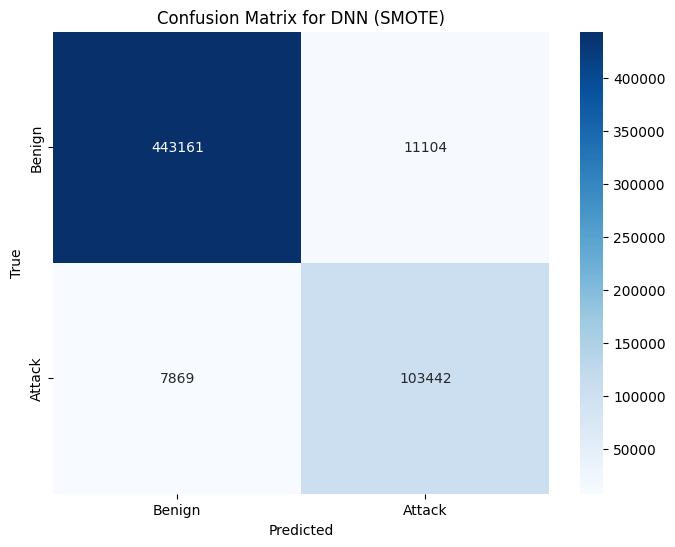

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.975556  SMOTE
1                     PortScan  0.951387  SMOTE
2                         DDoS  0.998203  SMOTE
3                     DoS Hulk  0.888083  SMOTE
4                DoS GoldenEye  0.991258  SMOTE
5                  FTP-Patator  0.980466  SMOTE
6                DoS slowloris  0.996549  SMOTE
7             DoS Slowhttptest  0.990909  SMOTE
8                          Bot  0.843990  SMOTE
9                  SSH-Patator  0.500847  SMOTE
10    Web Attack - Brute Force  0.086379  SMOTE
11            Web Attack - XSS  0.015385  SMOTE
12                  Heartbleed  0.000000  SMOTE
13  Web Attack - Sql Injection  0.250000  SMOTE
14                Infiltration  0.000000  SMOTE


In [15]:
# Define DNN model
def create_dnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create, train, and evaluate DNN model
dnn_model = create_dnn_model(X_smote_train.shape[1])
dnn_model.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, epochs=10, batch_size=32, 
              validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Evaluate and save the model
metrics["DNN"] = test_metrics_DL("DNN", dnn_model, scaler_smote, X_test, Y_test, reshape=False)
save_model(dnn_model, "DNN_SMOTE")


## CNN

Epoch 1/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 73s 871us/step - accuracy: 0.9361 - loss: 0.1427 - val_accuracy: 0.2783 - val_loss: 6.5045
Epoch 2/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 70s 840us/step - accuracy: 0.9586 - loss: 0.0939 - val_accuracy: 0.2785 - val_loss: 3.9165
Epoch 3/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 72s 864us/step - accuracy: 0.9620 - loss: 0.0856 - val_accuracy: 0.3058 - val_loss: 2.9072
Epoch 4/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 72s 857us/step - accuracy: 0.9641 - loss: 0.0806 - val_accuracy: 0.3995 - val_loss: 3.8302
Epoch 5/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 73s 873us/step - accuracy: 0.9659 - loss: 0.0775 - val_accuracy: 0.4439 - val_loss: 1.8272
Epoch 6/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 71s 846us/step - accuracy: 0.9672 - loss: 0.0752 - val_accuracy: 0.4492 - val_loss: 1.7356
Epoch 7/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 70s 845us/step - accuracy: 0.9686 - loss: 0.0734 - val_accuracy: 0.6561 - val_loss: 1.7759
Epoch 8/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 70s 845us/s

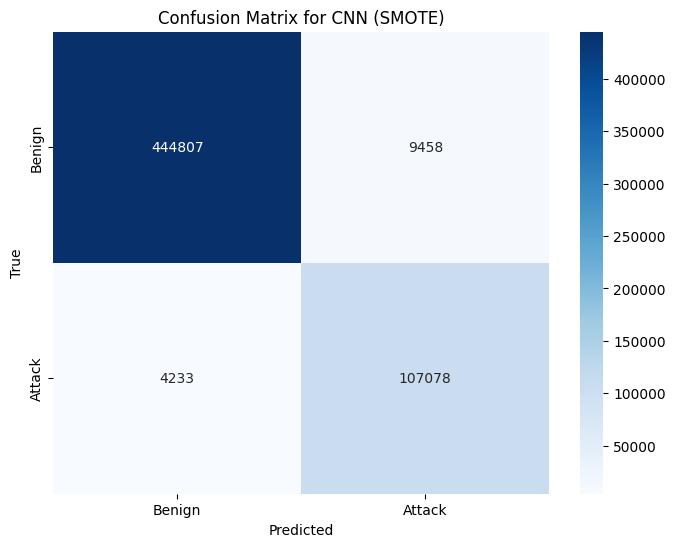

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.979180  SMOTE
1                     PortScan  0.947861  SMOTE
2                         DDoS  0.987307  SMOTE
3                     DoS Hulk  0.974079  SMOTE
4                DoS GoldenEye  0.993201  SMOTE
5                  FTP-Patator  0.998110  SMOTE
6                DoS slowloris  0.996549  SMOTE
7             DoS Slowhttptest  0.990909  SMOTE
8                          Bot  0.933504  SMOTE
9                  SSH-Patator  0.504237  SMOTE
10    Web Attack - Brute Force  0.066445  SMOTE
11            Web Attack - XSS  0.015385  SMOTE
12                  Heartbleed  1.000000  SMOTE
13  Web Attack - Sql Injection  0.000000  SMOTE
14                Infiltration  0.428571  SMOTE


In [16]:
# Define CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create, train, and evaluate CNN model
cnn_model = create_cnn_model((X_smote_train.shape[1], 1))

history = cnn_model.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, epochs=10, batch_size=32, 
                        validation_split=0.2, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Evaluate and save the model
metrics["CNN"] = test_metrics_DL("CNN", cnn_model, scaler_smote, X_test, Y_test, reshape=False)
save_model(cnn_model, "CNN_SMOTE")


## RNN

In [17]:
# Define RNN model
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create, train, and evaluate RNN model
rnn_model = create_rnn_model((X_smote_train.shape[1], 1))
rnn_model.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, epochs=10, batch_size=32, 
              validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 575s 7ms/step - accuracy: 0.9200 - loss: 0.1712 - val_accuracy: 0.2092 - val_loss: 3.0518
Epoch 2/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 589s 7ms/step - accuracy: 0.9612 - loss: 0.0875 - val_accuracy: 0.3582 - val_loss: 2.0846
Epoch 3/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 600s 7ms/step - accuracy: 0.9650 - loss: 0.0780 - val_accuracy: 0.2220 - val_loss: 2.1968
Epoch 4/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 559s 7ms/step - accuracy: 0.9666 - loss: 0.0741 - val_accuracy: 0.3970 - val_loss: 2.0842
Epoch 5/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 563s 7ms/step - accuracy: 0.9685 - loss: 0.0700 - val_accuracy: 0.3317 - val_loss: 2.1616
Epoch 6/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 577s 7ms/step - accuracy: 0.9704 - loss: 0.0664 - val_accuracy: 0.3081 - val_loss: 2.0439
Epoch 7/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 612s 7ms/step - accuracy: 0.9730 - loss: 0.0617 - val_accuracy: 0.2455 - val_loss: 2.1042
Epoch 8/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 585s 7ms/step - ac

17675/17675 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
Classification Report (Test RNN (SMOTE)):
              precision    recall  f1-score   support

           0     0.9902    0.9853    0.9877    454265
           1     0.9411    0.9601    0.9505    111311

    accuracy                         0.9803    565576
   macro avg     0.9656    0.9727    0.9691    565576
weighted avg     0.9805    0.9803    0.9804    565576

Accuracy: 0.9803244833585584
Precision: 0.9805191037875051
Recall: 0.9803244833585584
F1 Score: 0.9803982983905358
AUC: 0.9726877550450092


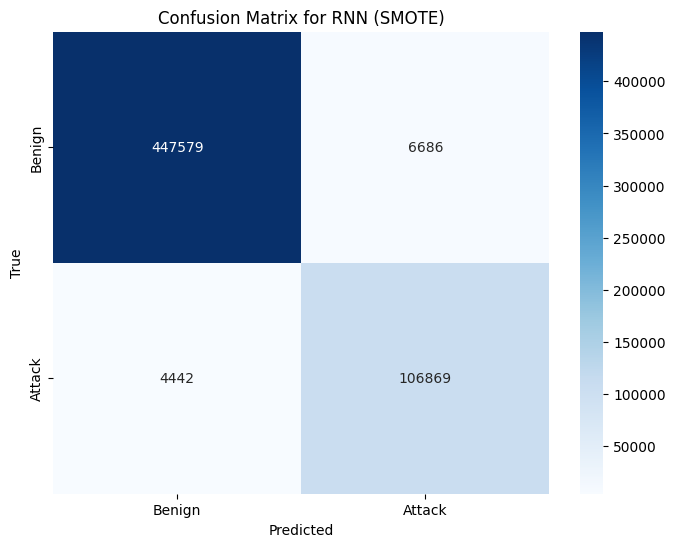

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.985282  SMOTE
1                     PortScan  0.947325  SMOTE
2                         DDoS  0.982503  SMOTE
3                     DoS Hulk  0.972232  SMOTE
4                DoS GoldenEye  0.992229  SMOTE
5                  FTP-Patator  0.998740  SMOTE
6                DoS slowloris  0.997412  SMOTE
7             DoS Slowhttptest  0.994545  SMOTE
8                          Bot  0.933504  SMOTE
9                  SSH-Patator  0.508475  SMOTE
10    Web Attack - Brute Force  0.093023  SMOTE
11            Web Attack - XSS  0.007692  SMOTE
12                  Heartbleed  1.000000  SMOTE
13  Web Attack - Sql Injection  0.250000  SMOTE
14                Infiltration  0.285714  SMOTE


In [18]:
# Evaluate and save the model
metrics["RNN"] = test_metrics_DL("RNN", rnn_model, scaler_smote, X_test, Y_test, reshape=False)
save_model(rnn_model, "RNN_SMOTE")

## Autoencoder

In [19]:
# Filter the training data to include only benign samples
benign_data = X_train[Y_train['is_attack'] == 0]

# Standardize the benign data
scaler_AE = StandardScaler()
scaler_AE.fit(benign_data)

# Define Autoencoder model
def create_autoencoder_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(input_shape, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create, train, and evaluate Autoencoder model
autoencoder_model = create_autoencoder_model(benign_data.shape[1])
autoencoder_model.fit(scaler_AE.transform(benign_data), scaler_AE.transform(benign_data), epochs=10, batch_size=32, 
                      validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


Epoch 1/10
45427/45427 ━━━━━━━━━━━━━━━━━━━━ 36s 758us/step - accuracy: 0.2771 - loss: -1487940352.0000 - val_accuracy: 0.4350 - val_loss: -53813321728.0000
Epoch 2/10
45427/45427 ━━━━━━━━━━━━━━━━━━━━ 34s 751us/step - accuracy: 0.2754 - loss: -244318666752.0000 - val_accuracy: 0.1090 - val_loss: -2044711927808.0000
Epoch 3/10
45427/45427 ━━━━━━━━━━━━━━━━━━━━ 33s 722us/step - accuracy: 0.2693 - loss: -4379454210048.0000 - val_accuracy: 0.0237 - val_loss: -18748654223360.0000
Epoch 4/10
45427/45427 ━━━━━━━━━━━━━━━━━━━━ 34s 746us/step - accuracy: 0.2724 - loss: -31124034158592.0000 - val_accuracy: 0.4349 - val_loss: -93835833114624.0000
Epoch 5/10
45427/45427 ━━━━━━━━━━━━━━━━━━━━ 34s 748us/step - accuracy: 0.2711 - loss: -136938791108608.0000 - val_accuracy: 0.4350 - val_loss: -332871273283584.0000
Epoch 6/10
45427/45427 ━━━━━━━━━━━━━━━━━━━━ 34s 750us/step - accuracy: 0.2744 - loss: -450550592176128.0000 - val_accuracy: 0.0819 - val_loss: -946249880567808.0000
Epoch 7/10
45427/45427 ━━━━━━

17675/17675 ━━━━━━━━━━━━━━━━━━━━ 9s 483us/step
Classification Report (Test AE (SMOTE)):
              precision    recall  f1-score   support

           0     0.8550    0.9581    0.9036    454265
           1     0.6635    0.3371    0.4471    111311

    accuracy                         0.8359    565576
   macro avg     0.7593    0.6476    0.6754    565576
weighted avg     0.8174    0.8359    0.8138    565576

Accuracy: 0.8358965019732096
Precision: 0.8173558706697455
Recall: 0.8358965019732096
F1 Score: 0.8137979104608581
AUC: 0.647626814010094


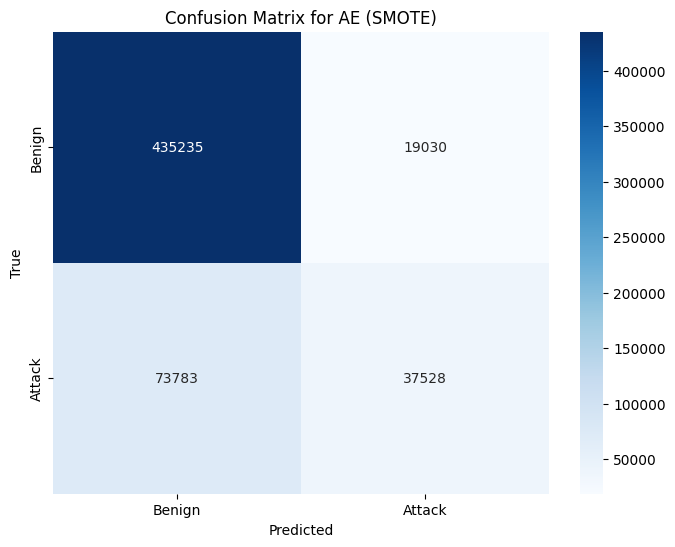

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.958108  SMOTE
1                     PortScan  0.009288  SMOTE
2                         DDoS  0.476587  SMOTE
3                     DoS Hulk  0.498403  SMOTE
4                DoS GoldenEye  0.598349  SMOTE
5                  FTP-Patator  0.015753  SMOTE
6                DoS slowloris  0.415876  SMOTE
7             DoS Slowhttptest  0.300000  SMOTE
8                          Bot  0.038363  SMOTE
9                  SSH-Patator  0.000847  SMOTE
10    Web Attack - Brute Force  0.000000  SMOTE
11            Web Attack - XSS  0.000000  SMOTE
12                  Heartbleed  1.000000  SMOTE
13  Web Attack - Sql Injection  0.000000  SMOTE
14                Infiltration  0.571429  SMOTE


In [20]:
# Evaluate and save the model
from notebook_utils import test_metrics_AE
metrics["AE"] = test_metrics_AE("AE", autoencoder_model, scaler_AE, X_test, Y_test, 90)
save_model(autoencoder_model, "AE_SMOTE")

In [35]:
from tensorflow.keras import Model, layers

# Filter the training data to include only benign samples
benign_data = X_train[Y_train['is_attack'] == 0]

# Standardize the benign data
scaler_AE = StandardScaler()
scaler_AE.fit(benign_data)

class AnomalyDetector(Model):
    def __init__(self, input_shape):
        super(AnomalyDetector, self).__init__()
        self.encoder = Sequential([
            layers.Dense(256, activation="relu", input_shape=(input_shape,)),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu")
        ])
        self.decoder = Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(input_shape, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_shape = benign_data.shape[1]
autoencoder = AnomalyDetector(input_shape)
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(scaler_AE.transform(benign_data), scaler_AE.transform(benign_data),
                          epochs=50, batch_size=512, validation_split=0.2, shuffle=True,
                          callbacks=[EarlyStopping(monitor='loss', patience=5)])

reconstructions = autoencoder.predict(scaler_AE.transform(benign_data))
train_loss = np.mean(np.abs(scaler_AE.transform(benign_data) - reconstructions), axis=1)

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.3815 - val_loss: 0.3694
Epoch 2/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3691 - val_loss: 0.3694
Epoch 3/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3697 - val_loss: 0.3694
Epoch 4/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3694 - val_loss: 0.3694
Epoch 5/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3698 - val_loss: 0.3694
Epoch 6/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3699 - val_loss: 0.3694
Epoch 7/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3696 - val_loss: 0.3694
Epoch 8/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3700 - val_loss: 0.3694
Epoch 9/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3699 - val_loss: 0.3694
Epoch 10/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3694 - val_loss: 0.3694
Epoch 11/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.3695 - val_loss: 0.3694
56783/56783 ━━━━━━━━━━━━━━━━

17675/17675 ━━━━━━━━━━━━━━━━━━━━ 9s 483us/step
Classification Report (Test AE (SMOTE)):
              precision    recall  f1-score   support

           0     0.8742    0.9041    0.8889    454265
           1     0.5450    0.4688    0.5040    111311

    accuracy                         0.8184    565576
   macro avg     0.7096    0.6864    0.6965    565576
weighted avg     0.8094    0.8184    0.8131    565576

Accuracy: 0.8184205128930506
Precision: 0.8093661976777013
Recall: 0.8184205128930506
F1 Score: 0.8131278337723019
AUC: 0.6864497138452477


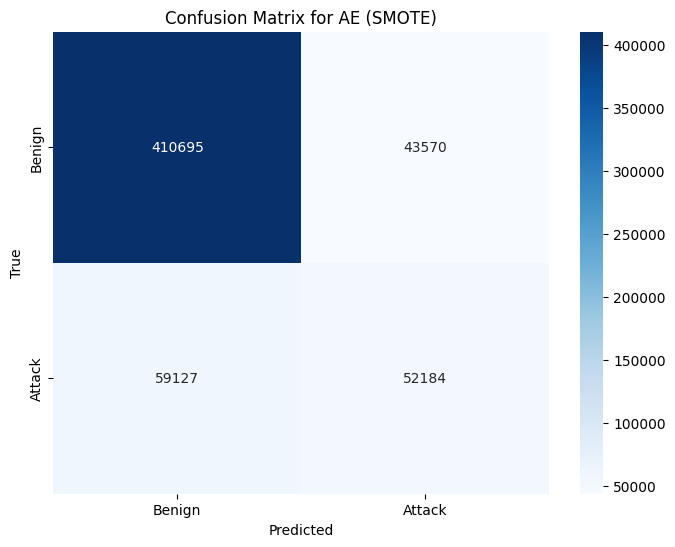

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.904087  SMOTE
1                     PortScan  0.012090  SMOTE
2                         DDoS  0.630853  SMOTE
3                     DoS Hulk  0.703639  SMOTE
4                DoS GoldenEye  0.793103  SMOTE
5                  FTP-Patator  0.015753  SMOTE
6                DoS slowloris  0.548749  SMOTE
7             DoS Slowhttptest  0.843636  SMOTE
8                          Bot  0.043478  SMOTE
9                  SSH-Patator  0.000847  SMOTE
10    Web Attack - Brute Force  0.039867  SMOTE
11            Web Attack - XSS  0.015385  SMOTE
12                  Heartbleed  1.000000  SMOTE
13  Web Attack - Sql Injection  0.250000  SMOTE
14                Infiltration  0.714286  SMOTE


In [36]:
# Evaluate and save the model
from notebook_utils import test_metrics_AE
metrics["AE"] = test_metrics_AE_new("AE", autoencoder_model, scaler_AE, X_test, Y_test, threshold)
save_model(autoencoder_model, "AE_SMOTE")